# Computational Theory

**Ethan Conneely (G00393941)**


Imports used for countdown

`random` was used for generating random games of countdown for the solver to solve.

`itertools` was used for getting the permutations for all the possible combinations of operations on the numbers.


In [45]:
import random
import itertools
import matplotlib.pyplot as plt
import statistics

# Game Rules

Here I have defined the rules for a valid game of countdown it can be used to generate a random game to test the solver on it.

The rules for the game are as follows:

- The player may choose the number of large numbers (25,50,75,100) to be used in the game 0-4.
  - The game then picks the number of large number from that list there will not be duplicates
- The remaining number are picked from a selection of 20 number from 1-10 each number is double up in the selection


In [46]:
def generate_game(bigNumbers) -> tuple[list[int], int]:
    if bigNumbers > 4 or bigNumbers < 0:
        raise ValueError("Invalid bigNumbers")

    largeNumbers = random.sample([25, 50, 75, 100], bigNumbers)
    smallNumbers = random.sample(
        list(range(1, 11)) + list(range(1, 11)), 6 - bigNumbers
    )

    numbers = largeNumbers + smallNumbers

    return (numbers, random.randint(101, 999))

Here is a lookup for the operations that can be done, division is integer division as we cannot at any point in the game have a decimal number this helps optimize the runtime of the algorithm.


In [47]:
ops = {
    "+": lambda x, y: x + y,
    "-": lambda x, y: x - y,
    "*": lambda x, y: x * y,
    "/": lambda x, y: x // y,  # integer division
}

In [48]:
def recursive_solve_countdown(numbers, target, calculations=[]):
    solutions: list = []

    # iterate over all pairs of numbers
    for pair in itertools.combinations(numbers, 2):
        # Make a copy and remove the pair from the list of numbers this will be passed down when we recursively sovle again
        computedNumbers = numbers.copy()
        computedNumbers.remove(pair[0])
        computedNumbers.remove(pair[1])

        # the reason this is fine for division is that if you ever divide
        # by a number on the left thats smaller than the right it would always be a decimal as its smaller than 1
        a = max(pair)
        b = min(pair)

        # Run the computation on each operator while doing some checks on division
        for op, calculate in ops.items():
            if a == 0 or b == 0:
                continue  # skip zero

            if op == "/" or op == "\\":

                if a == 1 or b == 1:
                    continue  # skip redundent division

            if op == "*" and (a == 1 or b == 1):
                continue  # skip redundent multiplication

            if op == "/":
                if a % b != 0:
                    continue  # skip none whole number division

            # reference the global variable for keeping track of the number of calculations
            global computation_count
            computation_count += 1

            # run the calculation using the lamda
            val = calculate(a, b)

            # Keep tract of the calculations done so far by creating a copy of the calculations list and appending
            # this gets passed onto the next recursive call so thats why we make a copy we dont want a different
            # operator mutating the calculations list
            calcs = calculations.copy()
            calcs.append((a, op, b, val))

            # We are done
            if val == target:
                solutions.append(calcs)

            # Recurse using the new value as one of the numbers
            new_solutions = recursive_solve_countdown(
                [val, *computedNumbers], target, calcs
            )

            for solution in new_solutions:
                solutions.append(solution)

    return solutions

Recursivly descend the expression tree to build up the string representation of the expression.


In [49]:
def operations_to_expressions(expr, operations):
    left = operations.get(expr[0])
    if left is None:
        left = expr[0]
    else:
        del operations[expr[0]]
        left = operations_to_expressions(left, operations)

    right = operations.get(expr[2])
    if right is None:
        right = expr[2]
    else:
        del operations[expr[2]]
        right = operations_to_expressions(right, operations)

    return f"({left}{expr[1]}{right})"

`get_expression_lookup` converts the operations that were done to its computed value e.g

```
1+2=3
```

So it would store it in the dictionary as key `3` value `1,+,3` this is used for quick lookup later when recursivly descending the expression tree.


In [50]:
def generate_expression_lookup(operations):
    expressions = {}
    for expr in operations:
        expressions[expr[3]] = (expr[0], expr[1], expr[2])
    return expressions

In [51]:
def print_unique_solutions(solutions):
    unique_expressions: dict[str, bool] = {}

    solutions.sort(key=lambda x: len(x))

    for operations in solutions:

        expressions = generate_expression_lookup(operations)

        expr_paren = operations_to_expressions(operations[-1], expressions)
        del expressions[operations[-1][3]]  # remove target expression

        # If we have expressions left over it mean some of the operations were not used so we can
        # skip this expression as we will encounter the none redundent one at some point to print
        if len(expressions) != 0:
            continue

        # remove solutions that result in the same expression
        if unique_expressions.get(expr_paren, False):
            continue

        unique_expressions[expr_paren] = True

        for expr in operations:
            print(f"{expr[0]} {expr[1]} {expr[2]} = {expr[3]}")

        res = float(eval(expr_paren))

        print(expr_paren + " = " + str(res))
        print()

        target = operations[-1][3]
        # assert that the evaluation is correct helps catch error when making optimizations
        assert res == float(target)

    print("Found expressions: ", len(solutions))
    print("Unique expressions: ", len(unique_expressions))

## Fixed Game


In [52]:
numbers = [75, 50, 2, 3, 7, 1]
target = 103
computation_count = 0

solutions = recursive_solve_countdown(numbers, target)

print_unique_solutions(solutions)

print(f"Computations: {computation_count:,}")

50 * 2 = 100
100 + 3 = 103
((50*2)+3) = 103.0

75 * 2 = 150
150 - 50 = 100
100 + 3 = 103
(((75*2)-50)+3) = 103.0

75 * 2 = 150
150 + 3 = 153
153 - 50 = 103
(((75*2)+3)-50) = 103.0

75 * 2 = 150
50 - 3 = 47
150 - 47 = 103
((75*2)-(50-3)) = 103.0

75 + 3 = 78
50 / 2 = 25
78 + 25 = 103
((75+3)+(50/2)) = 103.0

50 / 2 = 25
75 + 25 = 100
100 + 3 = 103
((75+(50/2))+3) = 103.0

50 / 2 = 25
25 + 3 = 28
75 + 28 = 103
(75+((50/2)+3)) = 103.0

3 + 1 = 4
7 * 4 = 28
75 + 28 = 103
(75+(7*(3+1))) = 103.0

75 + 50 = 125
125 - 1 = 124
7 * 3 = 21
124 - 21 = 103
(((75+50)-1)-(7*3)) = 103.0

75 + 50 = 125
7 * 3 = 21
125 - 21 = 104
104 - 1 = 103
(((75+50)-(7*3))-1) = 103.0

75 + 50 = 125
7 * 3 = 21
21 + 1 = 22
125 - 22 = 103
((75+50)-((7*3)+1)) = 103.0

75 - 3 = 72
50 / 2 = 25
25 * 7 = 175
175 - 72 = 103
(((50/2)*7)-(75-3)) = 103.0

75 - 3 = 72
50 * 7 = 350
350 / 2 = 175
175 - 72 = 103
(((50*7)/2)-(75-3)) = 103.0

75 - 7 = 68
68 / 2 = 34
34 * 3 = 102
102 + 1 = 103
((((75-7)/2)*3)+1) = 103.0

75 - 7 = 68
68

## Single Solution


In [53]:
numbers = [25, 50, 5, 9, 3, 10]
target = 899
computation_count = 0

solutions = recursive_solve_countdown(numbers, target)

print_unique_solutions(solutions)

print(f"Computations: {computation_count:,}")

50 * 9 = 450
450 - 3 = 447
447 * 10 = 4470
4470 + 25 = 4495
4495 / 5 = 899
(((((50*9)-3)*10)+25)/5) = 899.0

Found expressions:  1
Unique expressions:  1
Computations: 1,367,373


## Random Game


In [54]:
(numbers, target) = generate_game(3)

print("numbers", numbers)
print("target", target)
print()

computation_count = 0

solutions = recursive_solve_countdown(numbers, target)

print_unique_solutions(solutions)


print(f"Computations: {computation_count:,}")

numbers [50, 75, 25, 10, 10, 2]
target 337

75 + 10 = 85
85 + 2 = 87
25 * 10 = 250
250 + 87 = 337
((25*10)+((75+10)+2)) = 337.0

75 + 10 = 85
25 * 10 = 250
250 + 85 = 335
335 + 2 = 337
(((25*10)+(75+10))+2) = 337.0

75 + 10 = 85
25 * 10 = 250
250 + 2 = 252
252 + 85 = 337
(((25*10)+2)+(75+10)) = 337.0

75 + 2 = 77
77 + 10 = 87
25 * 10 = 250
250 + 87 = 337
((25*10)+((75+2)+10)) = 337.0

75 + 2 = 77
25 * 10 = 250
250 + 77 = 327
327 + 10 = 337
(((25*10)+(75+2))+10) = 337.0

75 + 2 = 77
25 * 10 = 250
250 + 10 = 260
260 + 77 = 337
(((25*10)+10)+(75+2)) = 337.0

25 * 10 = 250
250 + 75 = 325
325 + 10 = 335
335 + 2 = 337
((((25*10)+75)+10)+2) = 337.0

25 * 10 = 250
250 + 75 = 325
325 + 2 = 327
327 + 10 = 337
((((25*10)+75)+2)+10) = 337.0

25 * 10 = 250
250 + 75 = 325
10 + 2 = 12
325 + 12 = 337
(((25*10)+75)+(10+2)) = 337.0

25 * 10 = 250
250 + 10 = 260
260 + 75 = 335
335 + 2 = 337
((((25*10)+10)+75)+2) = 337.0

25 * 10 = 250
250 + 10 = 260
260 + 2 = 262
262 + 75 = 337
((((25*10)+10)+2)+75) = 33

> Will take a while to run 100 games

In [63]:
comps = []
solutions=[]

for i in range(100):
    computation_count = 0
    (numbers, target) = generate_game(3)
    solutions_count=len(recursive_solve_countdown(numbers, target))
    comps.append(computation_count)
    solutions.append(solutions_count)


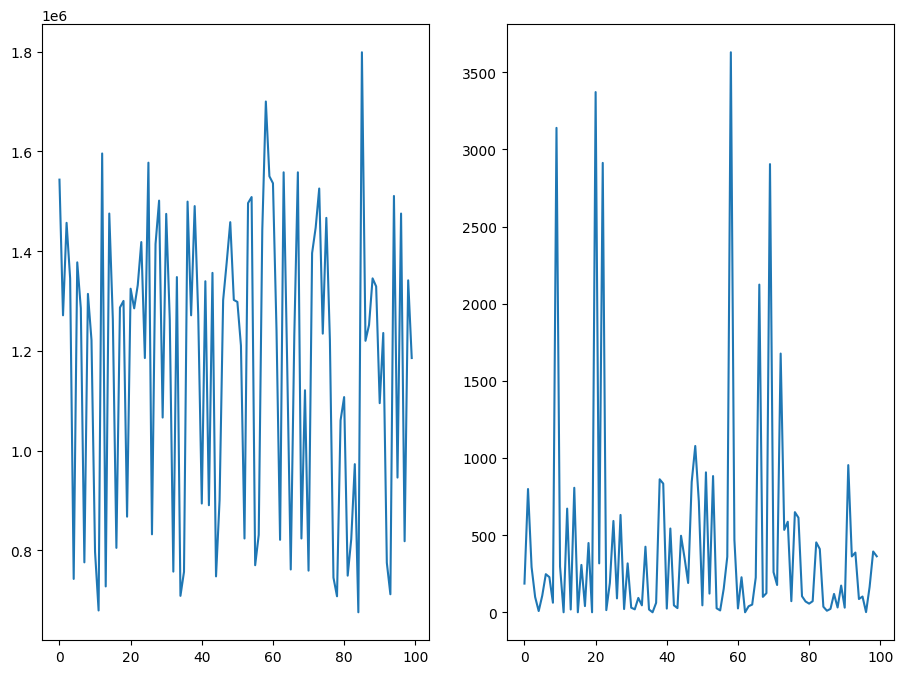

Mean number of computations per game 1,178,764.79
    Min 675,858
    Max 1,798,884
Mean number of solutions per game 443.18
    Min 0
    Max 3,630


In [65]:
# create the subplot axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 8))

# plot the images
ax1.plot(range(len(comps)), comps)
ax2.plot(range(len(solutions)), solutions)

plt.show()

print(f"Mean number of computations per game {statistics.mean(comps):,}")
print(f"    Min {min(comps):,}")
print(f"    Max {max(comps):,}")
print(f"Mean number of solutions per game {statistics.mean(solutions):,}")
print(f"    Min {min(solutions):,}")
print(f"    Max {max(solutions):,}")

# Comparison

When comparing my implementation to some online versions I found that my version removed more duplicate equations.

I compared the result to [dcode.fr](https://www.dcode.fr/countdown-numbers-game)

This is the game i used as a test

```shell
75, 50, 2, 3, 7
103
```

dcode.fr comes back with 15 equations found where as my implementation comes back with 13.

The reason for this is that dcode.fr does not remove duplicate equations if they are not in the same order. Here for example my implementation eliminates these into just 1 as they are the same expression in the end.

```shell
75 * 2 = 150
50 - 3 = 47
150 - 47 = 103
```

```shell
50 - 3 = 47
75 * 2 = 150
150 - 47 = 103
```

Both give this expression

`((75*2)-(50-3)) = 103.0`
